In [1]:
!pip install spacy
!pip install gensim

# Analysing the benefits of labelling with Word2Vec

The aim is to see if Word2Vec can use information from unlabelled data to help us classify better.

Data is sentiment data for yelps reviews.

This notebook is a simulation of the following situation: We have a **small** set of labelled data and a large set of unlabelled data. I aim to show how the 2 techniques compare as the amount of labelled data increases. The model is trained on the small labelled subset performance is tested on the remaining data.

In other words, we train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

The 2 scenarios are:

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Parameters are: training window size, K-negative, skip-gram vs BOW, training windows, etc.

Reference for  word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

# Load packages

In [28]:
# Install packages
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
stemmer = SnowballStemmer("english")
not_alphanumeric_or_space = re.compile('[^(\w|\s|\d)]')
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
set(stopwords.words('english'))
stop_words = stopwords.words('english')
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
import spacy
nlp = spacy.load('en_core_web_sm')

# Load files and sample

In [186]:
# Load files
yelps = pd.read_csv('yelps.csv')

yelps = yelps.dropna(axis = 0)

# Train test splits
Y = yelps.positive
X = yelps.text

# Take sample during development to increase speed
# X = X.sample(frac=0.1)
# Y = Y.sample(frac=0.1)

# Define functions

In [142]:
def preprocess(doc,  stop_words= stopwords.words('english')): 
''' Remove alphanumeric characters, decapitalise, lemmatise and remove stop words'''
        doc = doc.replace('-', ' ')
        doc = re.sub(not_alphanumeric_or_space, '', doc).lower() 
        words = [stemmer.stem(word) for word in doc.split() if word not in stop_words]
        return(words)


def embed_doc(doc, word_vecs):
'''Take one document within the whole corpus and transform onto continuous space'''
    res = np.zeros(word_vecs.vector_size)
    for word in doc:
        try: res += word_vecs.get_vector(word)
        except: pass
    res = res/np.linalg.norm(res)
    return res

def embed_all(corpus, word_vecs):
    embedded_docs = np.empty(shape=(len(corpus), word_vecs.vector_size))
    for i, doc in enumerate(corpus):
        embedded_docs[i]=embed_doc(doc, word_vecs)
    return(embedded_docs)

vectorizer = TfidfVectorizer(use_idf = False, # Use counts not idfs
                             norm= False, # We want actual counts not adjusted numbers
                             preprocessor = None, # Neat way of passing my preprocessor - note that it's not used here as we preprocess separately
                             min_df = 5, # Min occurrences of word across all docs
                             max_df = 0.85, # Max occurrences across all docs
                             stop_words = None) # Stop words removed during preprocessing

#  Prepare and embed

In [2]:
# Prepared X words
prep_X_words = [preprocess(doc) for doc in X]
# Prepared X documents
prep_X_docs = [' '.join(doc) for doc in prep_X_words]

# Define parameters for the word2Vec transformations (these should be tuned ideally)
embedding = 120
model = Word2Vec(prep_X_words, min_count=5, size=embedding, window = 8)
model.train(prep_X_words, total_examples=len(prep_X_words), epochs=8)
word_vecs = model.wv
del model

# Embed everything!
embedded_docs = embed_all(prep_X_words, word_vecs)

# Run

In [3]:
model = LogisticRegression(solver = 'liblinear')

all_simple_scores = []
all_embedded_scores = []
splits  = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 0.84, 0.92, 0.96, 0.98, 0.99]

for cut in splits:
    
    # Define test and train sets
    train_raw, test_raw, train_emb, test_emb, train_y, test_y = train_test_split(prep_X_docs, 
                                                                                embedded_docs, 
                                                                                Y, 
                                                                                train_size=(1- cut))

    # ** FIX NEEDED ** For some strange reason, 10 numbers get embedded as infinity values... 
    # Here I replace them with zeros to allow us to proceed; in reality they should be removed
    train_emb = np.array(pd.DataFrame(train_emb).fillna(0))
    test_emb = np.array(pd.DataFrame(test_emb).fillna(0))
    
    train_X = vectorizer.fit_transform(train_raw)
    test_X = vectorizer.transform(test_raw)
    
    model.fit(train_X, train_y)
    pred_Y = model.predict(test_X)   
    all_simple_scores.append(sum(pred_Y == test_y) /len(test_y))
    
    
    model.fit(train_emb, train_y)
    pred_Y = model.predict(test_emb)
    all_embedded_scores.append(sum(pred_Y==test_y)/len(test_y))

# Graph

In [256]:
# Prepare to graph
results1 = pd.DataFrame(all_simple_scores)
results1.loc[:, 1] = 'simple'
results1.loc[:, 2] = [str(i) for i in splits]
results2 = pd.DataFrame(all_embedded_scores)
results2.loc[:, 1] = 'embedded'
results2.loc[:, 2] = [str(i) for i in splits]
results = pd.concat([results1, results2])
results.columns  = ['Test accuracy score', 'Data preprocessing', '% data in test split']

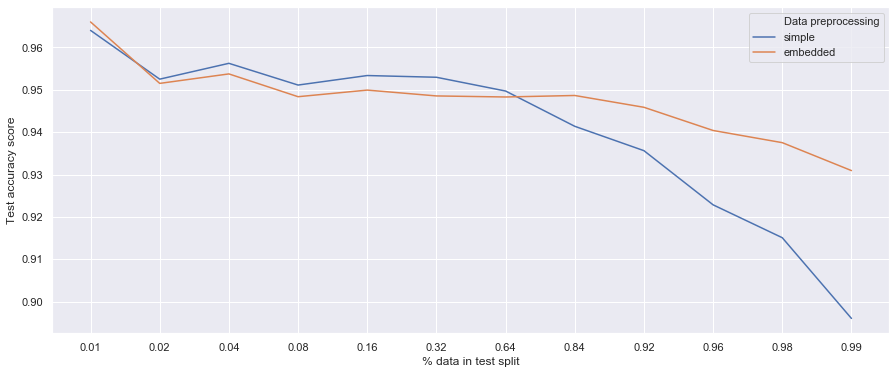

In [260]:
# Visualise results
sns.set(rc={'figure.figsize':(15,6)})
ax = sns.lineplot(x="% data in test split", y="Test accuracy score",  hue="Data preprocessing", data=results)

## Comments

- With a very small amount of data in training (on the RHS of the graph), our embedded docs are the clear winners.
- At some stage, when the ampunt of training data increases above some threshold(around 65%) in testing versus 35% in training, this trend reverses.
- I believe that with such small testing numbers, the results on the left hand side become unreliable.